Tyfenn Eloy  
Mathias Berthonneau  
Arthur-Louis Bonneau  
Loris Nezan

<h1 style="text-align:center">Process Mining</h1>
<h2 style="text-align:center">Project - Study of potential bias in the rental process</h2>

In [19]:
import pm4py
import pandas as pd
import matplotlib.pyplot as plt
import warnings

In [20]:
warnings.filterwarnings('ignore')

In [21]:
log_low = pm4py.read_xes('data/renting_log_low.xes')
log_medium = pm4py.read_xes('data/renting_log_medium.xes')
log_high = pm4py.read_xes('data/renting_log_high.xes')

parsing log, completed traces ::   0%|          | 0/10000 [00:00<?, ?it/s]

parsing log, completed traces ::   0%|          | 0/10000 [00:00<?, ?it/s]

parsing log, completed traces ::   0%|          | 0/10000 [00:00<?, ?it/s]

In [22]:
log_low.columns

Index(['activity', 'resource', 'time', 'concept:name', 'time:timestamp',
       '@@index', 'case:concept:name', 'case:german speaking',
       'case:yearsOfEducation', 'case:age', 'case:gender', 'case:citizen',
       'case:protected', 'case:married', 'case:@@case_index', 'case:case'],
      dtype='object')

## General trace analysis

In [23]:
CASE_ID_COL = 'concept:name'
ACTIVITY_COL = 'activity'
TIMESTAMP_COL = 'time:timestamp'

print(f"Case ID Column: {CASE_ID_COL}")
print(f"Activity Column: {ACTIVITY_COL}")
print(f"Timestamp Column: {TIMESTAMP_COL}")

Case ID Column: concept:name
Activity Column: activity
Timestamp Column: time:timestamp


Statistics for the `low` dataset:

In [24]:
num_cases = len(log_low.groupby(CASE_ID_COL))
num_events = len(log_low)

variants = pm4py.get_variants(log_low)
num_variants = len(variants)

print(f"Number of cases: {num_cases}")
print(f"Number of events: {num_events}")
print(f"Number of variants: {num_variants}")

Number of cases: 16
Number of events: 96440
Number of variants: 508


Statistics for the `medium` dataset:

In [25]:
num_cases = len(log_medium.groupby(CASE_ID_COL))
num_events = len(log_medium)

variants = pm4py.get_variants(log_medium)
num_variants = len(variants)

print(f"Number of cases: {num_cases}")
print(f"Number of events: {num_events}")
print(f"Number of variants: {num_variants}")

Number of cases: 16
Number of events: 105555
Number of variants: 610


Statistics for the `high` dataset:

In [26]:
num_cases = len(log_high.groupby(CASE_ID_COL))
num_events = len(log_high)

variants = pm4py.get_variants(log_high)
num_variants = len(variants)

print(f"Number of cases: {num_cases}")
print(f"Number of events: {num_events}")
print(f"Number of variants: {num_variants}")

Number of cases: 16
Number of events: 89972
Number of variants: 496


The general statistics of the different datasets are similar in term of size. We will be able to compare them easily.

## Drawing a general diagram of the flow

In [27]:
from pm4py.algo.discovery.alpha import algorithm as alpha_miner

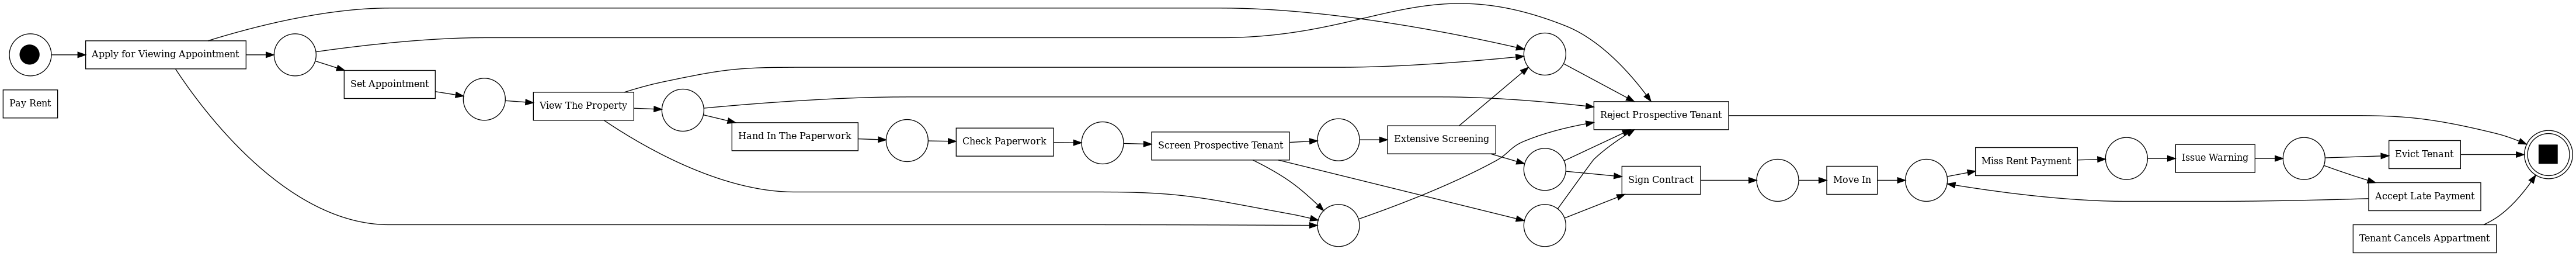

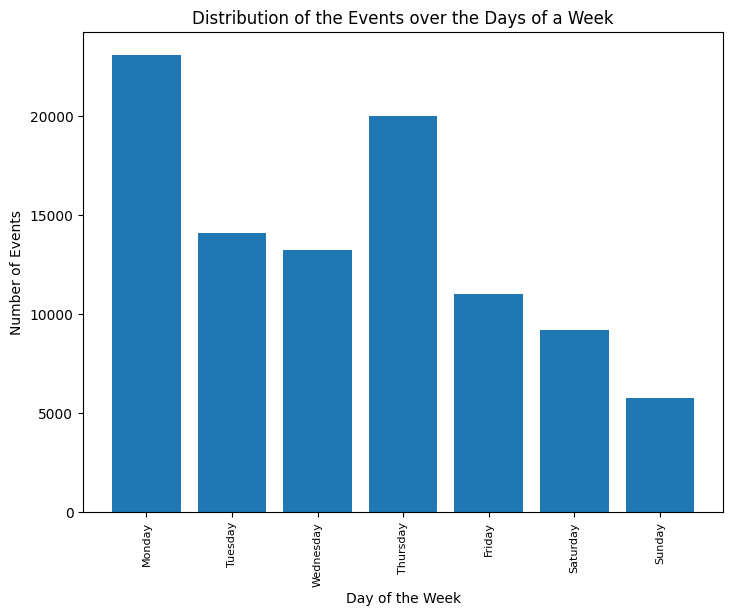

({('Accept Late Payment', 'Miss Rent Payment'): 37,
  ('Accept Late Payment', 'Pay Rent'): 894,
  ('Apply for Viewing Appointment', 'Reject Prospective Tenant'): 643,
  ('Apply for Viewing Appointment', 'Set Appointment'): 9357,
  ('Check Paperwork', 'Screen Prospective Tenant'): 8049,
  ('Extensive Screening', 'Reject Prospective Tenant'): 1592,
  ('Extensive Screening', 'Sign Contract'): 1093,
  ('Hand In The Paperwork', 'Check Paperwork'): 8049,
  ('Issue Warning', 'Accept Late Payment'): 931,
  ('Issue Warning', 'Evict Tenant'): 137,
  ('Miss Rent Payment', 'Issue Warning'): 1068,
  ('Move In', 'Miss Rent Payment'): 165,
  ('Move In', 'Pay Rent'): 3245,
  ('Pay Rent', 'Miss Rent Payment'): 866,
  ('Pay Rent', 'Pay Rent'): 16868,
  ('Pay Rent', 'Tenant Cancels Appartment'): 3273,
  ('Screen Prospective Tenant', 'Extensive Screening'): 2685,
  ('Screen Prospective Tenant', 'Reject Prospective Tenant'): 3047,
  ('Screen Prospective Tenant', 'Sign Contract'): 2317,
  ('Set Appointment'

In [28]:
net, initial_marking, final_marking = alpha_miner.apply(log_low)

pm4py.view_petri_net(net, initial_marking, final_marking)

# pm4py.view_case_duration_graph(log_low)

pm4py.view_events_distribution_graph(log_low)

pm4py.discover_directly_follows_graph(log_low)

# pm4py.discover_network_analysis(log_low, out_column=CASE_ID_COL, in_column=CASE_ID_COL, node_column_source='resource', node_column_target='resource', edge_column='concept:name')

In [29]:
tree = pm4py.discover_prefix_tree(log_low)
# pm4py.view_prefix_tree(tree)

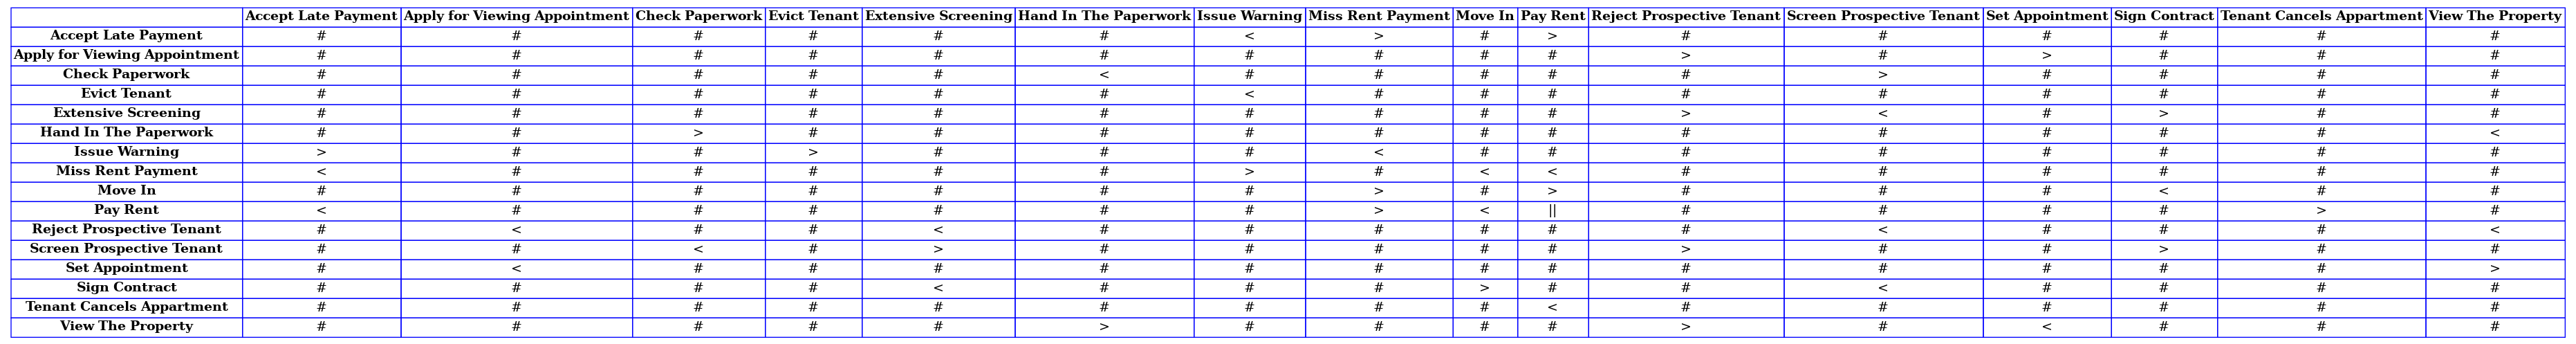

In [30]:
pm4py.view_footprints(pm4py.discover_footprints(log_low))

In [31]:
declare = pm4py.discover_declare(log_low)
diag = pm4py.conformance_declare(log_low, declare, return_diagnostics_dataframe=True)

In [32]:
diag

,case_id,no_dev_total,no_constr_total,dev_fitness
0,1,0,182,1.000000
1,10,84,182,0.538462
2,100,0,182,1.000000
3,1000,0,182,1.000000
4,10000,84,182,0.538462
...,...,...,...,...
9995,9995,84,182,0.538462
9996,9996,4,182,0.978022
9997,9997,0,182,1.000000
9998,9998,0,182,1.000000


In the renting process, we can identify 4 main steps:

- The user is applying for a place
- The landlord is accepting or rejecting the application
- The user is paying the rent or not
- The user can get evicted or not

Based on this, we can look for potential bias in the process regarding the additional information we have on the users :

- Age
- Education
- Gender
- Citizenship
- Life situation (marriage, single)

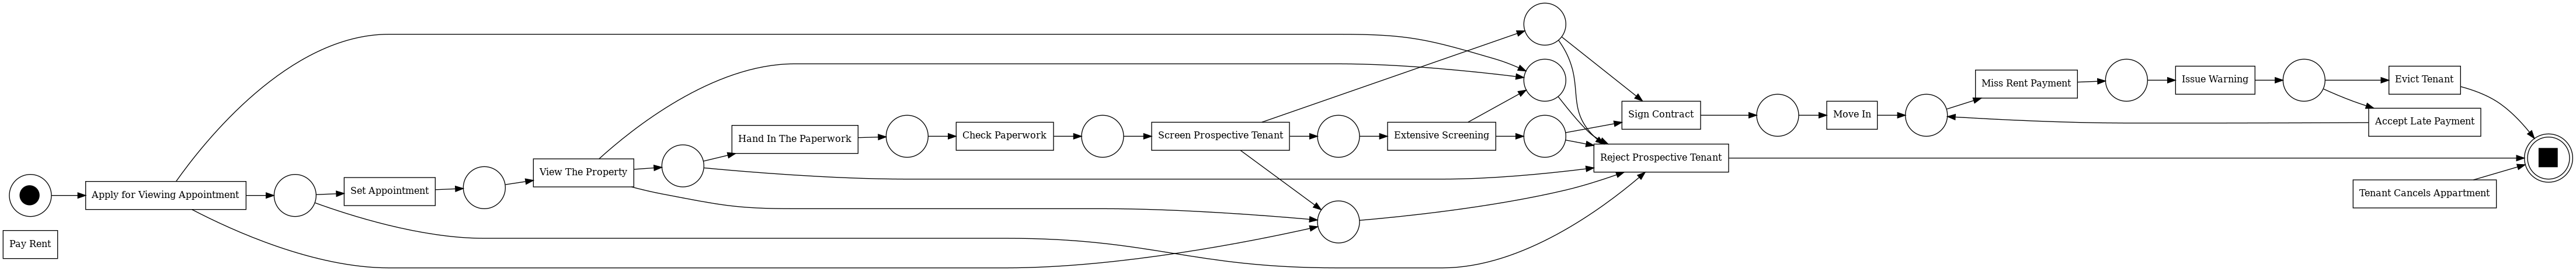

In [33]:
# split per "case:age"
log_young_low = log_low[log_low['case:age'] < 25]
log_middle_low = log_low[(log_low['case:age'] >= 25) & (log_low['case:age'] <= 50)]
log_old_low = log_low[log_low['case:age'] > 50]

net, initial_marking, final_marking = alpha_miner.apply(log_old_low)
pm4py.view_petri_net(net, initial_marking, final_marking)

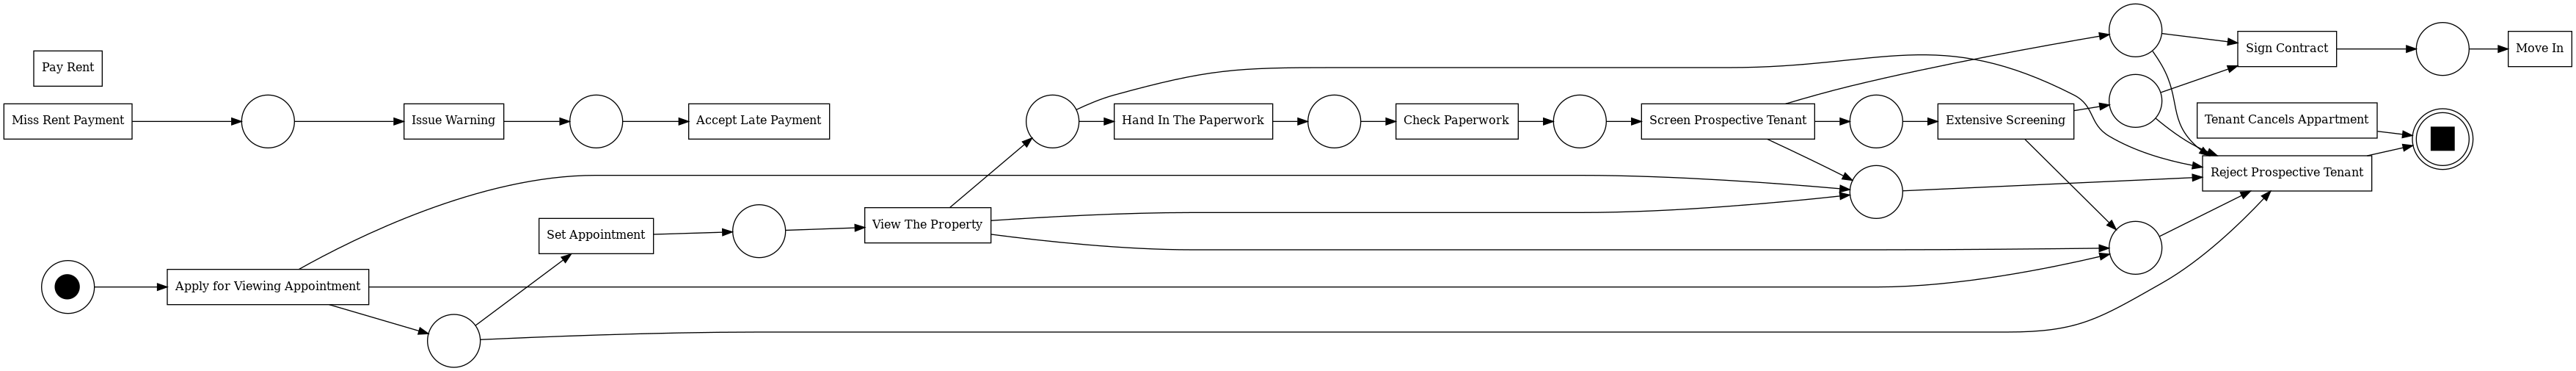

In [34]:
# split per "case:yearsOfEducation"

log_uneducated_low = log_low[log_low['case:yearsOfEducation'] < 5]
log_medium_education_low = log_low[(log_low['case:yearsOfEducation'] >= 5) & (log_low['case:yearsOfEducation'] <= 15)]
log_high_education_low = log_low[log_low['case:yearsOfEducation'] > 16]

net, initial_marking, final_marking = alpha_miner.apply(log_high_education_low)
pm4py.view_petri_net(net, initial_marking, final_marking)

In [35]:

def printSexism(log, logName):
    
    # split per "case:age"
    log_male = log[log['case:gender'] ==  True]
    log_female = log[log['case:gender'] == False]
    nb_trace_male = len(log_male)
    nb_trace_female = len(log_female)

    # Get len events "Sign Contract" 
    signed_contract_male = len(log_male[log_male['activity'] == 'Sign Contract'])
    signed_contract_female = len(log_female[log_female['activity'] == 'Sign Contract'])

    # Get len events "Reject Prospective Tenant"
    rejected_contract_male = len(log_male[log_male['activity'] == 'Reject Prospective Tenant'])
    rejected_contract_female = len(log_female[log_female['activity'] == 'Reject Prospective Tenant'])

    # get % of rejected contract
    pc_reject_male = nb_trace_male/rejected_contract_male
    pc_reject_female = nb_trace_female/rejected_contract_female

    # get % of accepted contract
    pc_signed_male = nb_trace_male/signed_contract_male
    pc_signed_female = nb_trace_female/signed_contract_female

    #Print the results
    print("-"*30)
    print("Event log: " + logName)
    print("Nombre traces hommes: {}, nombre de signatures: {}, nombre de refus: {}".format(nb_trace_male, signed_contract_male, rejected_contract_male))
    print("-- % refus: {}, % acceptation: {}".format(pc_reject_male, pc_signed_male))
    print("Nombre traces femme: {}, nombre de signatures: {}, nombre de refus: {}".format(nb_trace_female, signed_contract_female, rejected_contract_female))
    print("-- % refus: {}, % acceptation: {}".format(pc_reject_female, pc_signed_female))
    print("-"*30)

In [36]:
printSexism(log_low, "low")
printSexism(log_medium, "medium")
printSexism(log_high, "high")

------------------------------
Event log: low
Nombre traces hommes: 54204, nombre de signatures: 1970, nombre de refus: 3557
-- % refus: 15.238684284509418, % acceptation: 27.51472081218274
Nombre traces femme: 42236, nombre de signatures: 1440, nombre de refus: 3033
-- % refus: 13.925486317177711, % acceptation: 29.330555555555556
------------------------------
------------------------------
Event log: medium
Nombre traces hommes: 51694, nombre de signatures: 2032, nombre de refus: 2861
-- % refus: 18.068507514854947, % acceptation: 25.43996062992126
Nombre traces femme: 53861, nombre de signatures: 2131, nombre de refus: 2976
-- % refus: 18.098454301075268, % acceptation: 25.274988268418582
------------------------------
------------------------------
Event log: high
Nombre traces hommes: 55329, nombre de signatures: 1823, nombre de refus: 3966
-- % refus: 13.950832072617247, % acceptation: 30.350521119034557
Nombre traces femme: 34643, nombre de signatures: 947, nombre de refus: 326

In [58]:
#On cherche a trouver les discrimntion dans les logs
#Cette fois ci on vas regarder les contrats accéptés en fonction de l'age 

def printAgeism(log, logName):
    #split per "case:age"
    log_young = log[log['case:age'] < 25]
    log_middle = log[(log['case:age'] >= 25) & (log['case:age'] <= 50)]
    log_old = log[log['case:age'] > 50]

    # Get len events "Sign Contract" for each age
    signed_contract_young = len(log_young[log_young['activity'] == 'Sign Contract'])
    signed_contract_middle = len(log_middle[log_middle['activity'] == 'Sign Contract'])
    signed_contract_old = len(log_old[log_old['activity'] == 'Sign Contract'])

    # Get len events "Reject Prospective Tenant" for each age
    rejected_contract_young = len(log_young[log_young['activity'] == 'Reject Prospective Tenant'])
    rejected_contract_middle = len(log_middle[log_middle['activity'] == 'Reject Prospective Tenant'])
    rejected_contract_old = len(log_old[log_old['activity'] == 'Reject Prospective Tenant'])

    # get % of rejected contract for each age
    pc_reject_young = rejected_contract_young / len(log_young) * 100
    pc_reject_middle = rejected_contract_middle/len(log_middle) * 100
    pc_reject_old = rejected_contract_old/len(log_old) * 100

    # get % of accepted contract for each age
    pc_signed_young = signed_contract_young/len(log_young) * 100
    pc_signed_middle = signed_contract_middle/len(log_middle) * 100
    pc_signed_old = signed_contract_old/len(log_old) * 100




    #Print the results
    print("-"*30)
    print("Event log: " + logName)
    print("Nombre traces jeunes: {}, nombre de signatures: {}, nombre de refus: {}".format(len(log_young), signed_contract_young, rejected_contract_young))
    print("-- % refus: {}, % acceptation: {}".format(pc_reject_young, pc_signed_young))
    print("Nombre traces moyen: {}, nombre de signatures: {}, nombre de refus: {}".format(len(log_middle), signed_contract_middle, rejected_contract_middle))
    print("-- % refus: {}, % acceptation: {}".format(pc_reject_middle, pc_signed_middle))
    print("Nombre traces vieux: {}, nombre de signatures: {}, nombre de refus: {}".format(len(log_old), signed_contract_old, rejected_contract_old))
    print("-- % refus: {}, % acceptation: {}".format(pc_reject_old, pc_signed_old))

printAgeism(log_low, "low")
printAgeism(log_medium, "medium")
printAgeism(log_high, "high")

------------------------------
Event log: low
Nombre traces jeunes: 311, nombre de signatures: 11, nombre de refus: 24
-- % refus: 7.717041800643088, % acceptation: 3.536977491961415
Nombre traces moyen: 46932, nombre de signatures: 1731, nombre de refus: 2961
-- % refus: 6.30912810023012, % acceptation: 3.688315008949118
Nombre traces vieux: 49197, nombre de signatures: 1668, nombre de refus: 3605
-- % refus: 7.327682582271276, % acceptation: 3.390450637233978
------------------------------
Event log: medium
Nombre traces jeunes: 397, nombre de signatures: 18, nombre de refus: 20
-- % refus: 5.037783375314862, % acceptation: 4.534005037783375
Nombre traces moyen: 52724, nombre de signatures: 2123, nombre de refus: 2783
-- % refus: 5.278431075032244, % acceptation: 4.026629239056217
Nombre traces vieux: 52434, nombre de signatures: 2022, nombre de refus: 3034
-- % refus: 5.786321852233284, % acceptation: 3.856276461837739
------------------------------
Event log: high
Nombre traces jeu

In [66]:
# Ageism regarding eviction 

def AgeismEviction (log, logName):
    #split per "case:age" by tens from 20 to 80
    log_young = log[(log['case:age'] >= 20) & (log['case:age'] <= 30)]
    log_middle = log[(log['case:age'] >= 30) & (log['case:age'] <= 40)]
    log_old = log[(log['case:age'] >= 40) & (log['case:age'] <= 50)]
    log_very_old = log[(log['case:age'] >= 50) & (log['case:age'] <= 60)]
    log_ancient = log[(log['case:age'] >= 60) & (log['case:age'] <= 70)]
    log_very_ancient = log[(log['case:age'] >= 70) & (log['case:age'] <= 80)]
    # Note : les noms de variables sont funny

    # Get len events "Evict Tenant" for each age
    evict_young = len(log_young[log_young['activity'] == 'Evict Tenant'])
    evict_middle = len(log_middle[log_middle['activity'] == 'Evict Tenant'])
    evict_old = len(log_old[log_old['activity'] == 'Evict Tenant'])
    evict_very_old = len(log_very_old[log_very_old['activity'] == 'Evict Tenant'])
    evict_ancient = len(log_ancient[log_ancient['activity'] == 'Evict Tenant']) 
    evict_very_ancient = len(log_very_ancient[log_very_ancient['activity'] == 'Evict Tenant'])

    # # For each age, get the number of cases
    nb_trace_young = len(log_young)
    nb_trace_middle = len(log_middle)
    nb_trace_old = len(log_old)
    nb_trace_very_old = len(log_very_old)
    nb_trace_ancient = len(log_ancient)
    nb_trace_very_ancient = len(log_very_ancient)

    # get % of evicted contract for each age
    pc_evict_young = evict_young / len(log_young) * 100
    pc_evict_middle = evict_middle/len(log_middle) * 100
    pc_evict_old = evict_old/len(log_old) * 100
    pc_evict_very_old = evict_very_old/len(log_very_old) * 100
    pc_evict_ancient = evict_ancient/len(log_ancient) * 100
    pc_evict_very_ancient = evict_very_ancient/len(log_very_ancient) * 100
    

    #Print the results
    print("-"*30)
    print("Event log: " + logName)
    print("Nombre traces jeunes: {}, nombre de evictions: {}".format(nb_trace_young, evict_young))
    print("-- % evictions: {}".format(pc_evict_young))
    print("Nombre traces moyen: {}, nombre de evictions: {}".format(nb_trace_middle, evict_middle))
    print("-- % evictions: {}".format(pc_evict_middle))
    print("Nombre traces vieux: {}, nombre de evictions: {}".format(nb_trace_old, evict_old))
    print("-- % evictions: {}".format(pc_evict_old))
    print("Nombre traces très vieux: {}, nombre de evictions: {}".format(nb_trace_very_old, evict_very_old))
    print("-- % evictions: {}".format(pc_evict_very_old))
    print("Nombre traces ancien: {}, nombre de evictions: {}".format(nb_trace_ancient, evict_ancient))
    print("-- % evictions: {}".format(pc_evict_ancient))
    print("Nombre traces très ancien: {}, nombre de evictions: {}".format(nb_trace_very_ancient, evict_very_ancient))
    print("-- % evictions: {}".format(pc_evict_very_ancient))

AgeismEviction(log_low, "low")
AgeismEviction(log_medium, "medium")
AgeismEviction(log_high, "high")

------------------------------
Event log: low
Nombre traces jeunes: 1712, nombre de evictions: 4
-- % evictions: 0.23364485981308408
Nombre traces moyen: 12199, nombre de evictions: 9
-- % evictions: 0.07377653906057874
Nombre traces vieux: 35681, nombre de evictions: 50
-- % evictions: 0.1401306017208038
Nombre traces très vieux: 36176, nombre de evictions: 56
-- % evictions: 0.15479876160990713
Nombre traces ancien: 17039, nombre de evictions: 31
-- % evictions: 0.181935559598568
Nombre traces très ancien: 3172, nombre de evictions: 6
-- % evictions: 0.18915510718789408
------------------------------
Event log: medium
Nombre traces jeunes: 1936, nombre de evictions: 3
-- % evictions: 0.15495867768595042
Nombre traces moyen: 14615, nombre de evictions: 32
-- % evictions: 0.2189531303455354
Nombre traces vieux: 39488, nombre de evictions: 80
-- % evictions: 0.2025931928687196
Nombre traces très vieux: 37255, nombre de evictions: 76
-- % evictions: 0.20399946315930745
Nombre traces anci